In [2]:
import yfinance as yf
import pandas as pd
from statsforecast import StatsForecast
import numpy as np

/Users/beneverman/Documents/Coding/bp-quant/model-experiments-v1/venv/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
tickers = ['SPY', 'MSFT', 'AAPL', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'META', 'NKE', 'NFLX'] 
df = yf.download(tickers, start = '2018-01-01', end = '2022-12-31', interval='1d') # use daily prices

[*********************100%%**********************]  10 of 10 completed


In [10]:
type(df.index.values[0])

numpy.datetime64

In [10]:
saved = df.copy()

In [11]:
df.head()

Adj Close                                               \
                 AAPL       AMZN       GOOG        META       MSFT   
Date                                                                 
2018-01-01  39.633194  72.544502  58.497002  186.889999  88.865959   
2018-02-01  42.163677  75.622498  55.236500  178.320007  87.706131   
2018-03-01  39.877975  72.366997  51.589500  159.789993  85.768845   
2018-04-01  39.279018  78.306503  50.866501  172.000000  87.883209   
2018-05-01  44.415283  81.481003  54.249500  191.779999  92.882568   

                                                                     ...  \
                  NFLX        NKE       NVDA         SPY       TSLA  ...   
Date                                                                 ...   
2018-01-01  270.299988  64.317024  60.808376  255.980576  23.620667  ...   
2018-02-01  291.380005  63.195107  59.868294  246.672958  22.870667  ...   
2018-03-01  295.350006  62.638878  57.328571  238.954514  17.742001  ...   
2018-04-01  312.459991  64.672333  55.672504  241.151489  19.593332  ...   
2018-05-01  351.600006  67.896980  62.427963  247.013672  18.982000  ...   

                Volume                                               \
                  AAPL        AMZN       GOOG       META       MSFT   
Date                                                                  
2018-01-01  2638717600  1927424000  574768000  495655700  574258400   
2018-02-01  3711577200  2755680000  847640000  516251600  725663300   
2018-03-01  2854910800  2608002000  907066000  996201700  750754800   
2018-04-01  2664617200  2598392000  834318000  750072700  668130700   
2018-05-01  2483905200  1432310000  636988000  401144100  509417900   

                                                                      
                 NFLX        NKE        NVDA         SPY        TSLA  
Date                                                                  
2018-01-01  238377600  157812200  1145621600  1985506700  1864072500  
2018-02-01  184585800  160317000  1491552800  2923722000  1637850000  
2018-03-01  263449400  174066700  1411844000  2323561800  2359027500  
2018-04-01  262006000  158981900  1114400800  1998466500  2854662000  
2018-05-01  142050800  129566300  1197824000  1606397200  2333671500  

[5 rows x 60 columns]

In [12]:
df = df.loc[:, (['Adj Close'], tickers)] # just get adj close
df.columns = df.columns.droplevel() # drop MultiIndex
df = df.reset_index() # reset index
df.head()

# ? this is in place so if you run it twice it will break, and you will have to re-run the download

,Date,SPY,MSFT,AAPL,GOOG,AMZN,TSLA,NVDA,META,NKE,NFLX
0,2018-01-01,255.980576,88.865959,39.633194,58.497002,72.544502,23.620667,60.808376,186.889999,64.317024,270.299988
1,2018-02-01,246.672958,87.706131,42.163677,55.236500,75.622498,22.870667,59.868294,178.320007,63.195107,291.380005
2,2018-03-01,238.954514,85.768845,39.877975,51.589500,72.366997,17.742001,57.328571,159.789993,62.638878,295.350006
3,2018-04-01,241.151489,87.883209,39.279018,50.866501,78.306503,19.593332,55.672504,172.000000,64.672333,312.459991
4,2018-05-01,247.013672,92.882568,44.415283,54.249500,81.481003,18.982000,62.427963,191.779999,67.896980,351.600006


In [13]:
prices = df.melt(id_vars='Date')

In [14]:
prices

,Date,variable,value
0,2018-01-01,SPY,255.980576
1,2018-02-01,SPY,246.672958
2,2018-03-01,SPY,238.954514
3,2018-04-01,SPY,241.151489
4,2018-05-01,SPY,247.013672
...,...,...,...
595,2022-08-01,NFLX,223.559998
596,2022-09-01,NFLX,235.440002
597,2022-10-01,NFLX,291.880005
598,2022-11-01,NFLX,305.529999


In [15]:
prices = prices.rename(columns={'Date': 'ds', 'variable': 'unique_id', 'value': 'y'}) # rename columns
prices = prices[['unique_id', 'ds', 'y']] # limit columns

In [16]:
prices

,unique_id,ds,y
0,SPY,2018-01-01,255.980576
1,SPY,2018-02-01,246.672958
2,SPY,2018-03-01,238.954514
3,SPY,2018-04-01,241.151489
4,SPY,2018-05-01,247.013672
...,...,...,...
595,NFLX,2022-08-01,223.559998
596,NFLX,2022-09-01,235.440002
597,NFLX,2022-10-01,291.880005
598,NFLX,2022-11-01,305.529999


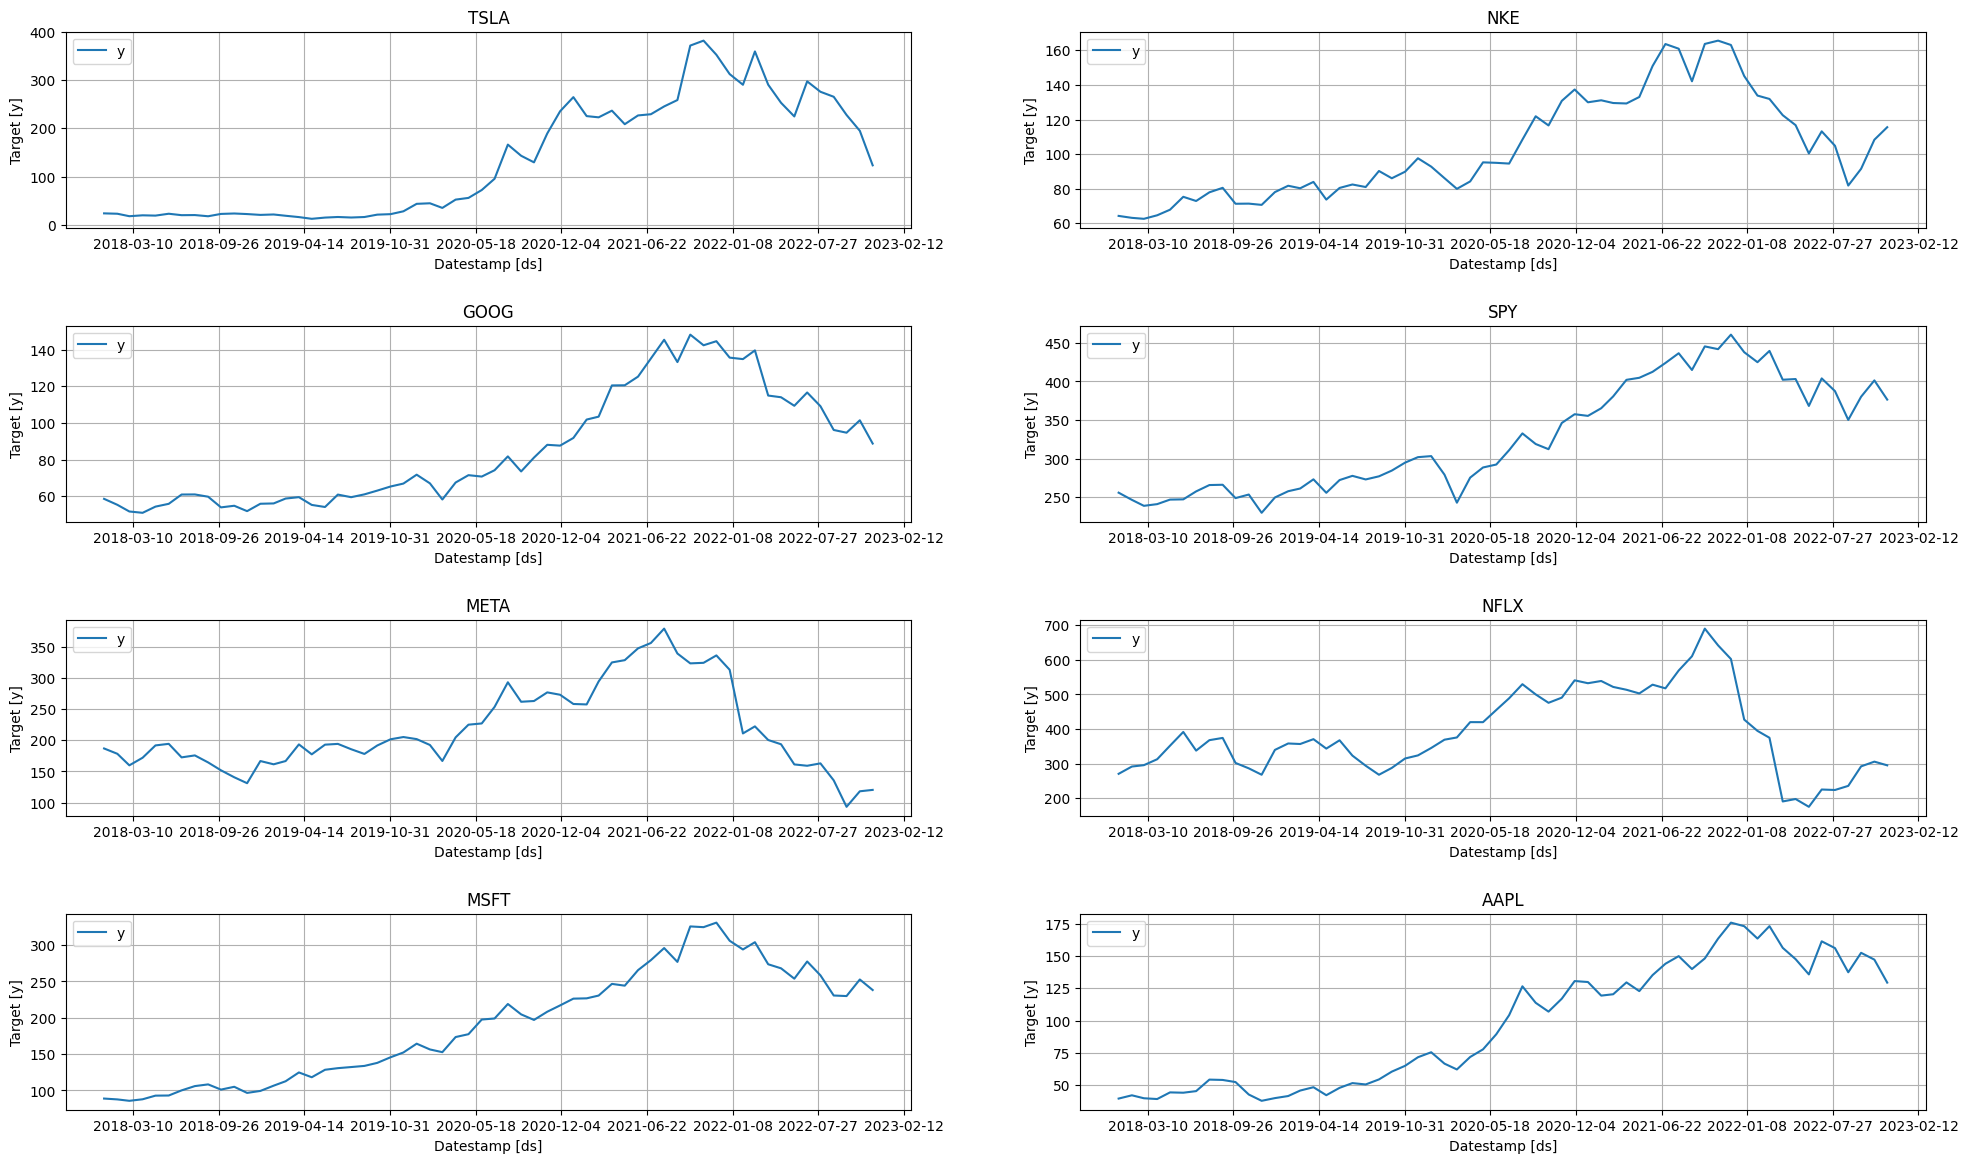

In [18]:
StatsForecast.plot(prices)

In [20]:
prices_copy = prices.copy()

## Try returns calc my way

In [24]:
def log_returns(series): # same thing
    return np.log(series).diff()

prices['rt-custom'] = prices.groupby('unique_id')['y'].transform(log_returns) # make sure to group by unique_id

In [25]:
prices # same hting

,unique_id,ds,y,rt,rt-custom
0,SPY,2018-01-01,255.980576,NaN,NaN
1,SPY,2018-02-01,246.672958,-0.037038,-0.037038
2,SPY,2018-03-01,238.954514,-0.031790,-0.031790
3,SPY,2018-04-01,241.151489,0.009152,0.009152
4,SPY,2018-05-01,247.013672,0.024018,0.024018
...,...,...,...,...,...
595,NFLX,2022-08-01,223.559998,-0.005976,-0.005976
596,NFLX,2022-09-01,235.440002,0.051776,0.051776
597,NFLX,2022-10-01,291.880005,0.214887,0.214887
598,NFLX,2022-11-01,305.529999,0.045705,0.045705


In [21]:
prices['rt'] = prices['y'].div(prices.groupby('unique_id')['y'].shift(1)) # calculate returns
prices['rt'] = np.log(prices['rt']) # take log of returns

returns = prices[['unique_id', 'ds', 'rt']] # limit columns
returns = returns.rename(columns={'rt': 'y'}) # rename columns
returns

,unique_id,ds,y
0,SPY,2018-01-01,NaN
1,SPY,2018-02-01,-0.037038
2,SPY,2018-03-01,-0.031790
3,SPY,2018-04-01,0.009152
4,SPY,2018-05-01,0.024018
...,...,...,...
595,NFLX,2022-08-01,-0.005976
596,NFLX,2022-09-01,0.051776
597,NFLX,2022-10-01,0.214887
598,NFLX,2022-11-01,0.045705


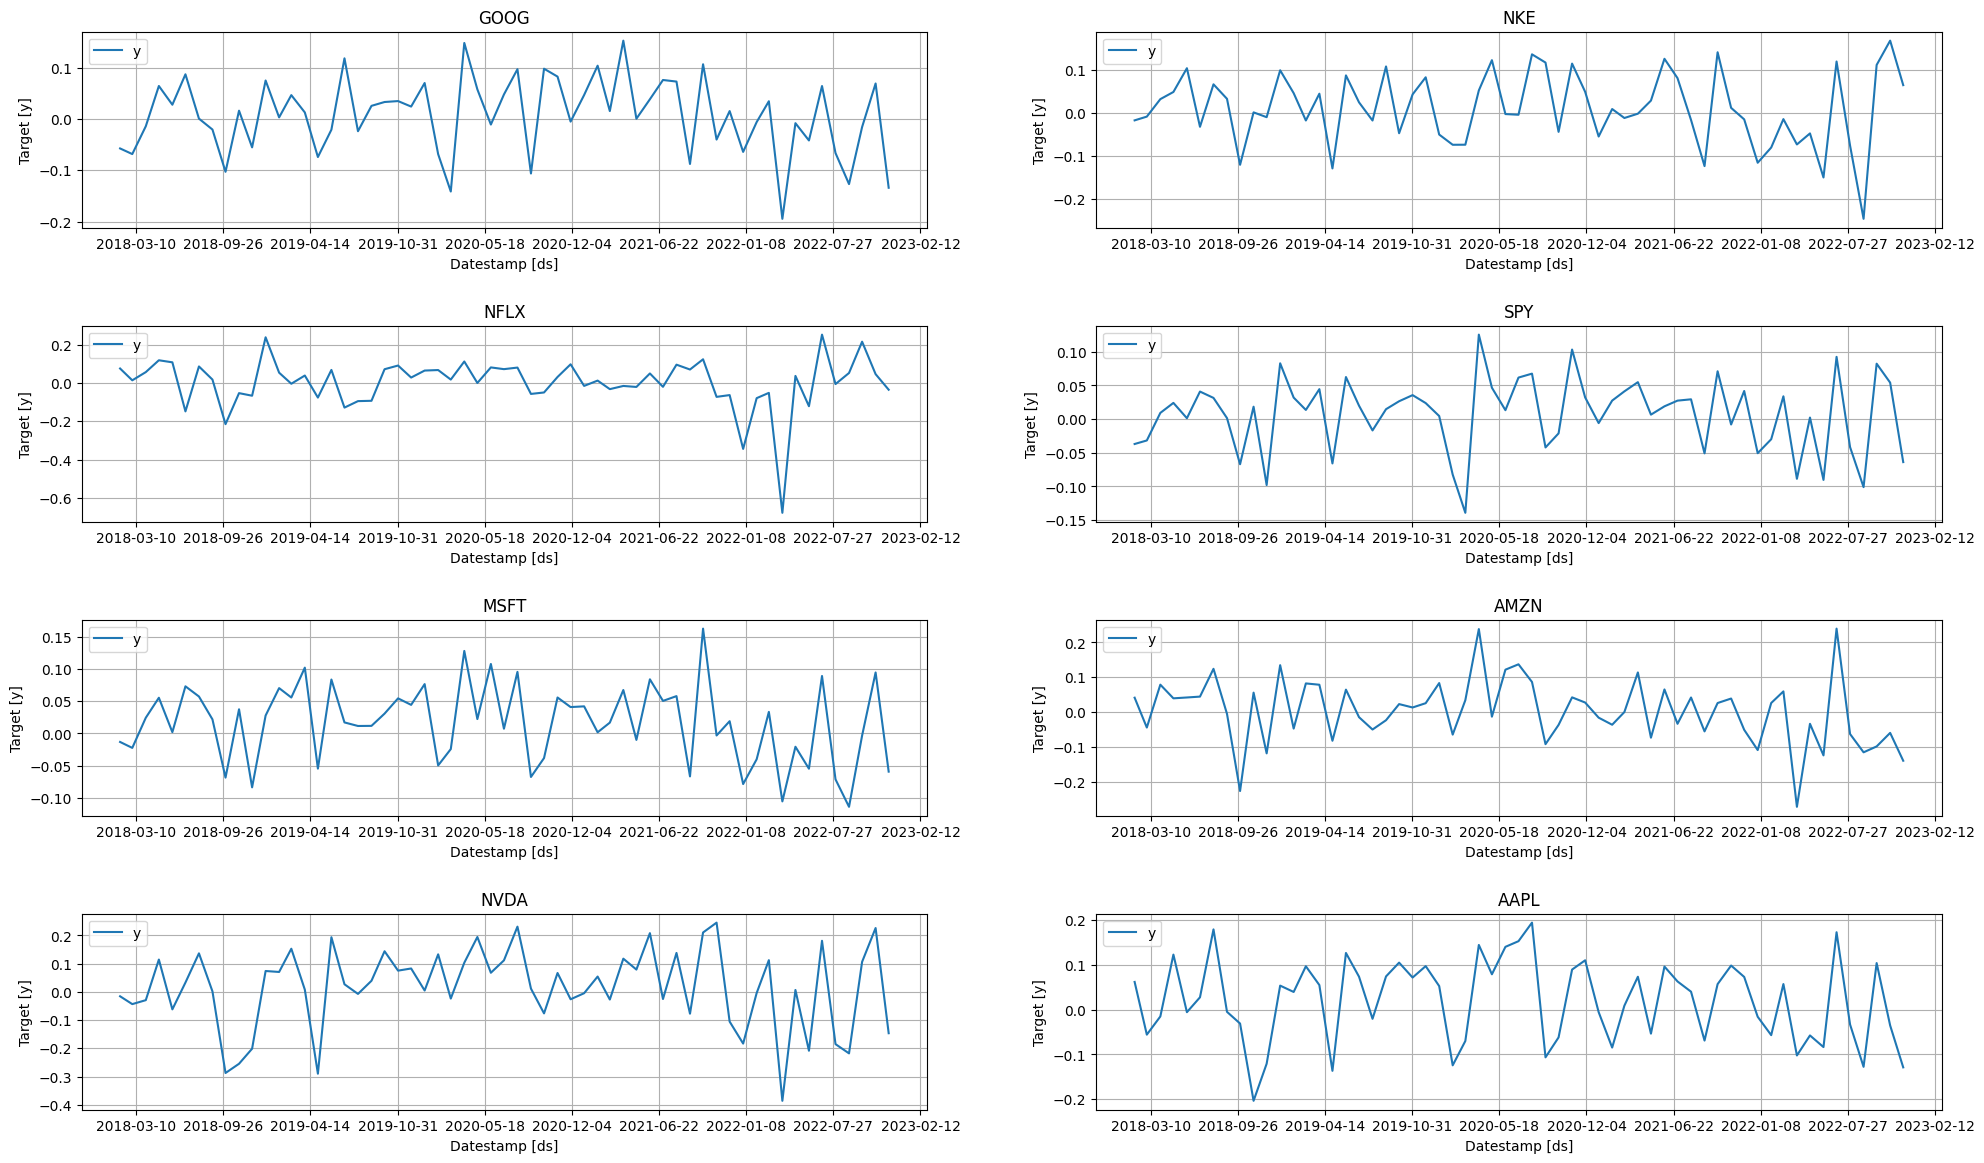

In [26]:
StatsForecast.plot(returns)

In [27]:
from statsforecast.models import (
    GARCH, 
    ARCH, 
    Naive
)

In [28]:
models = [ARCH(1), 
          ARCH(2), 
          GARCH(1,1),
          GARCH(1,2),
          GARCH(2,2),
          GARCH(2,1),
          Naive()
]

In [29]:
sf = StatsForecast(
    df = returns, 
    models = models, 
    freq = 'MS',
    n_jobs = -1 # -1 selects all available cores
)

In [30]:
crossvalidation_df = sf.cross_validation(
    df = returns,
    h = 3, # forecast horizon
    step_size = 3, # step size between forecasts
    n_windows = 4 # number of windows to use
)

In [31]:
crossvalidation_df = crossvalidation_df.reset_index()
crossvalidation_df.rename(columns = {'y' : 'actual'}, inplace = True)
crossvalidation_df.head()

,unique_id,ds,cutoff,actual,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
0,AAPL,2022-01-01,2021-12-01,-0.015837,0.221147,0.144016,0.142956,0.141687,0.141675,0.144020,0.073061
1,AAPL,2022-02-01,2021-12-01,-0.056855,-0.085072,-0.057160,-0.056391,-0.058789,-0.058780,-0.057162,0.073061
2,AAPL,2022-03-01,2021-12-01,0.057156,-0.071976,-0.046479,-0.047514,-0.045713,-0.045709,-0.046480,0.073061
3,AAPL,2022-04-01,2022-03-01,-0.102178,0.138652,0.140218,0.136213,0.136123,0.136123,0.140228,0.057156
4,AAPL,2022-05-01,2022-03-01,-0.057505,-0.056014,-0.056270,-0.054598,-0.057081,-0.057079,-0.056271,0.057156


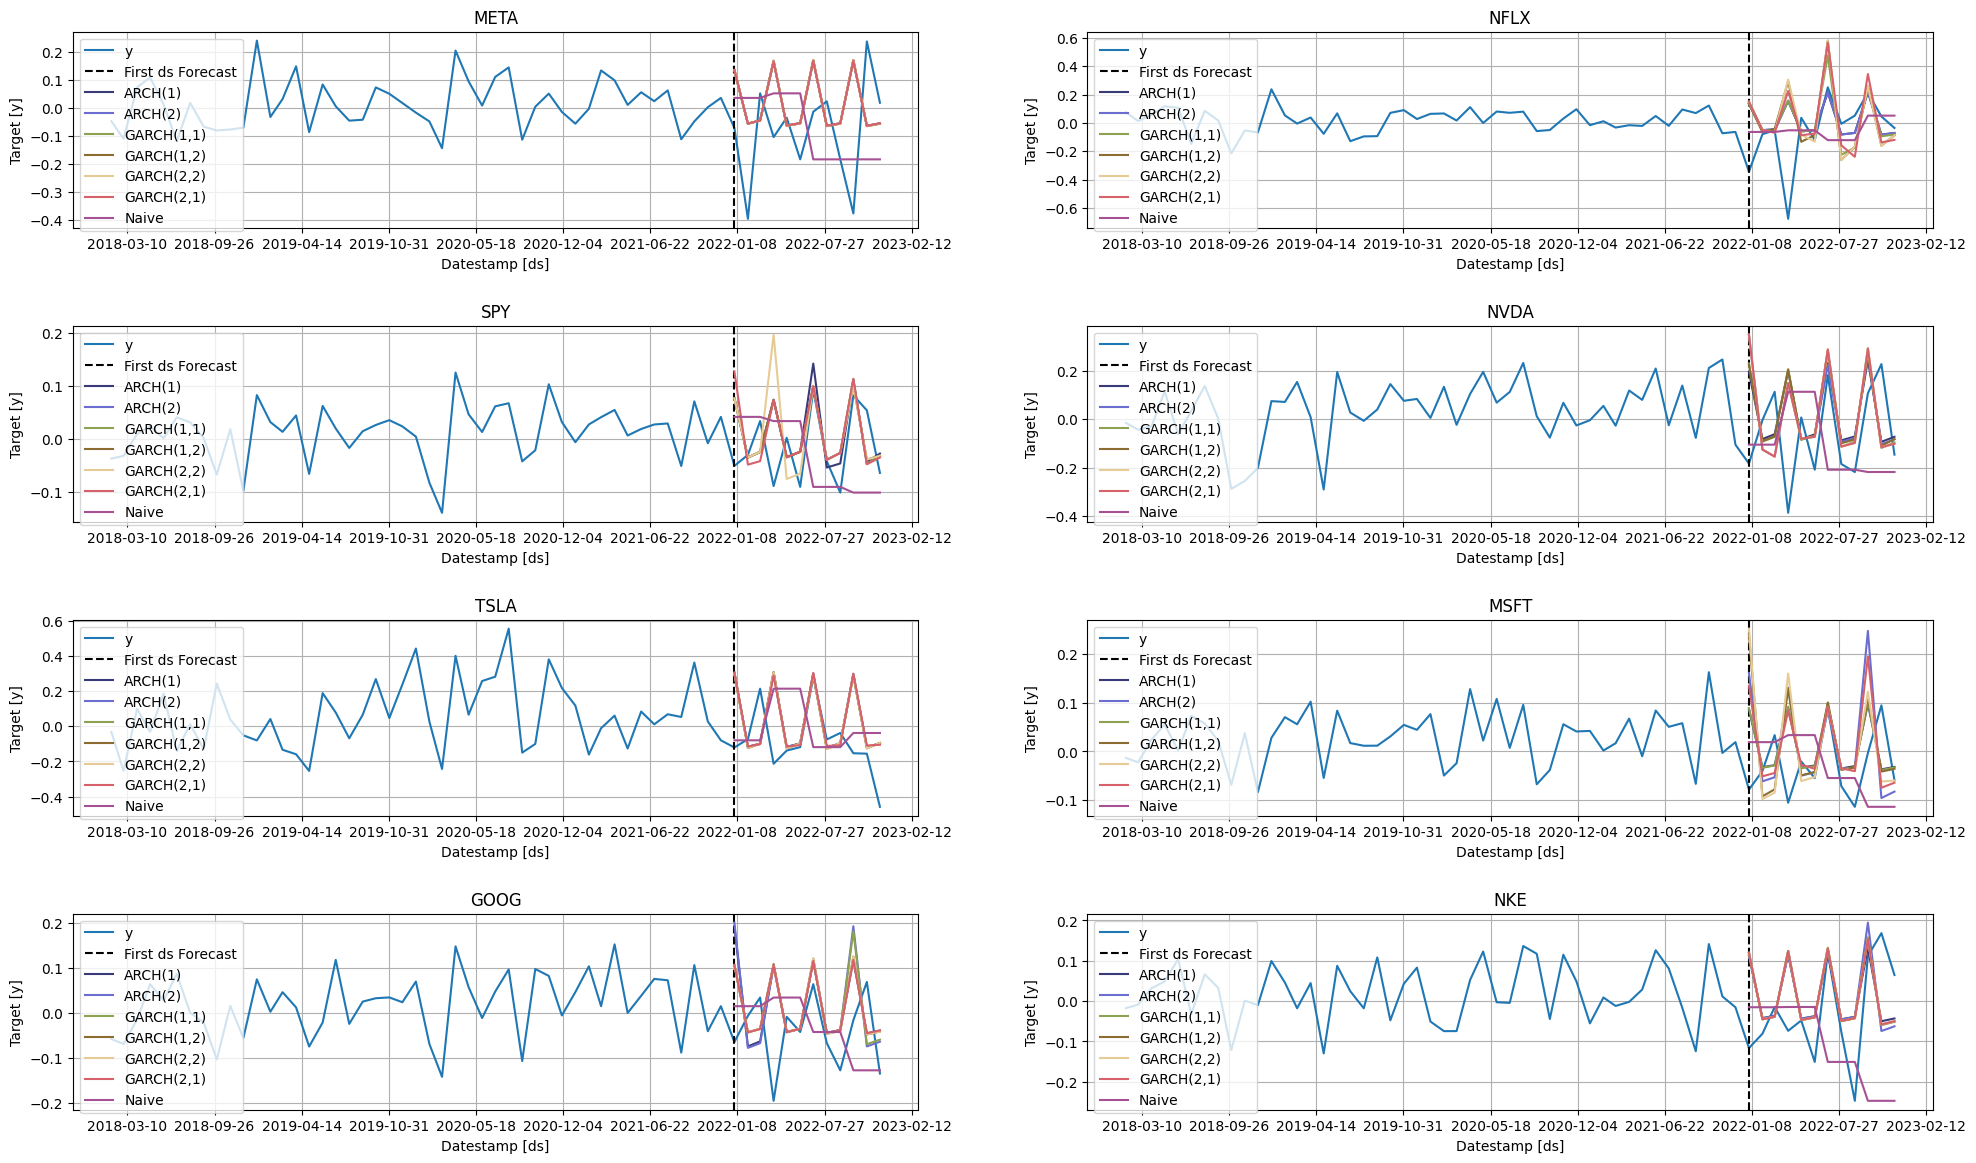

In [32]:
StatsForecast.plot(returns, crossvalidation_df.drop(['cutoff', 'actual'], axis=1))

In [33]:
from datasetsforecast.losses import mae

In [34]:
def compute_cv_mae(crossvalidation_df):
    """Compute MAE for all models generated"""
    res = {}
    for mod in models: # loop through models
        res[mod] = mae(crossvalidation_df['actual'], crossvalidation_df[str(mod)]) # compute MAE
    return pd.Series(res) # return as Series

In [35]:
mae_cv = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(compute_cv_mae)

mae = mae_cv.groupby('unique_id').mean()
mae.style.highlight_min(color = 'lightblue', axis = 1)

,ARCH(1),ARCH(2),"GARCH(1,1)","GARCH(1,2)","GARCH(2,2)","GARCH(2,1)",Naive
unique_id,,,,,,,
AAPL,0.079925,0.068927,0.073116,0.072263,0.069183,0.068642,0.110425
AMZN,0.127390,0.113613,0.118859,0.119930,0.109910,0.109910,0.115189
GOOG,0.105818,0.113711,0.099471,0.094647,0.094520,0.093752,0.083233
META,0.198334,0.198891,0.199617,0.199712,0.199711,0.198892,0.185346
MSFT,0.070768,0.100698,0.071706,0.096127,0.100604,0.083334,0.086951
NFLX,0.159386,0.159528,0.199623,0.232477,0.230076,0.230770,0.167421
NKE,0.098643,0.107560,0.103368,0.102709,0.102706,0.102707,0.160405
NVDA,0.189459,0.207875,0.199007,0.197854,0.211922,0.211928,0.215289
SPY,0.061216,0.058582,0.058701,0.057051,0.067304,0.065349,0.089012


In [37]:
levels = [80, 95] # confidence levels for the prediction intervals 

forecasts = sf.forecast(h=3, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

,unique_id,ds,ARCH(1),ARCH(1)-lo-95,ARCH(1)-lo-80,ARCH(1)-hi-80,ARCH(1)-hi-95,ARCH(2),ARCH(2)-lo-95,ARCH(2)-lo-80,...,"GARCH(2,1)","GARCH(2,1)-lo-95","GARCH(2,1)-lo-80","GARCH(2,1)-hi-80","GARCH(2,1)-hi-95",Naive,Naive-lo-80,Naive-lo-95,Naive-hi-80,Naive-hi-95
0,AAPL,2023-01-01,0.150450,0.133636,0.139456,0.161445,0.167265,0.150161,0.133411,0.139209,...,0.147616,0.131429,0.137032,0.158199,0.163802,-0.128762,-0.284463,-0.366886,0.026939,0.109362
1,AAPL,2023-02-01,-0.056939,-0.073918,-0.068041,-0.045837,-0.039960,-0.057208,-0.074349,-0.068416,...,-0.059514,-0.078063,-0.071642,-0.047385,-0.040965,-0.128762,-0.348956,-0.465520,0.091433,0.207997
2,AAPL,2023-03-01,-0.048390,-0.064841,-0.059147,-0.037633,-0.031938,-0.049281,-0.066343,-0.060437,...,-0.054541,-0.075441,-0.068207,-0.040875,-0.033641,-0.128762,-0.398444,-0.541205,0.140920,0.283681
3,AMZN,2023-01-01,0.152147,0.134952,0.140904,0.163391,0.169343,0.148658,0.132242,0.137924,...,0.148599,0.132196,0.137873,0.159324,0.165001,-0.139141,-0.315716,-0.409190,0.037435,0.130909
4,AMZN,2023-02-01,-0.057301,-0.074497,-0.068545,-0.046058,-0.040106,-0.061187,-0.080794,-0.074007,...,-0.069303,-0.094457,-0.085750,-0.052856,-0.044150,-0.139141,-0.388856,-0.521048,0.110575,0.242767


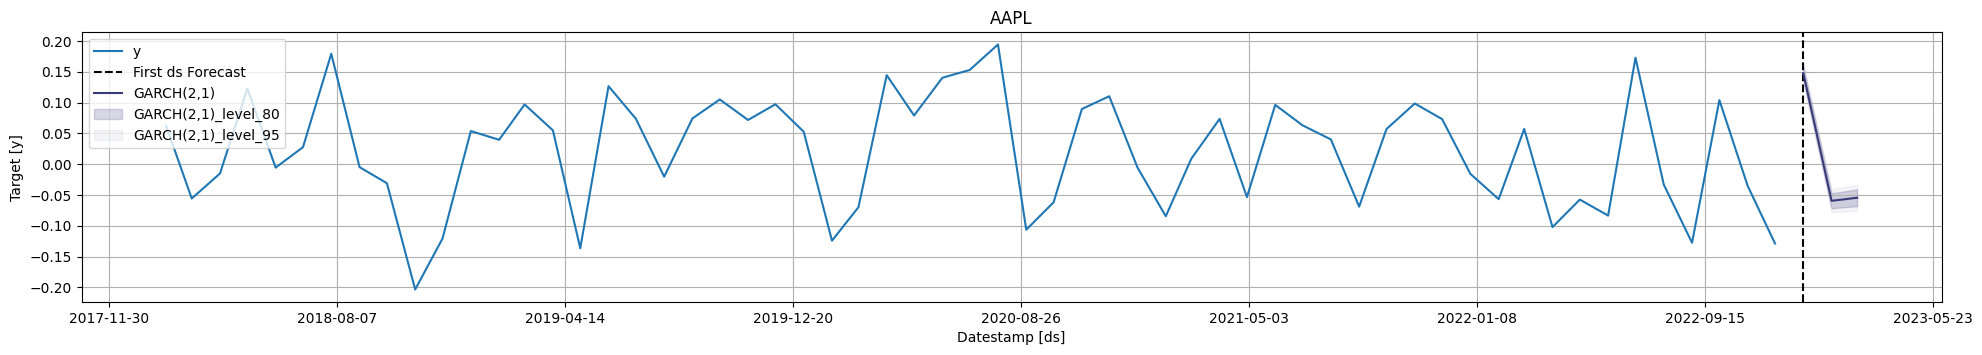

In [38]:
StatsForecast.plot(returns, forecasts, level=levels, unique_ids = ['AAPL'], models = ['GARCH(2,1)'])

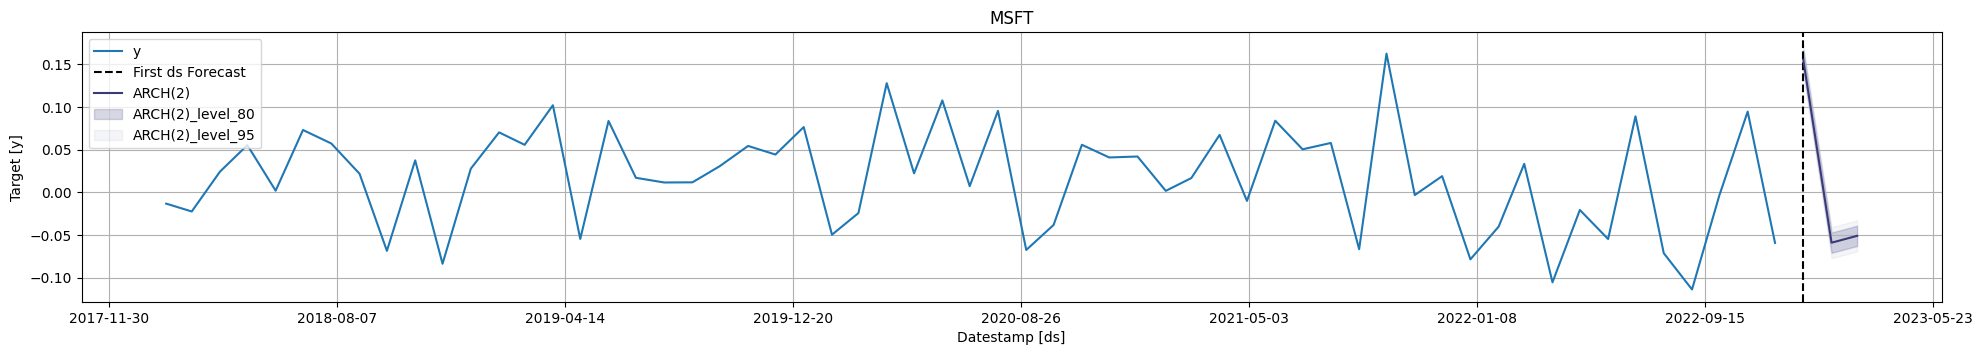

In [39]:
StatsForecast.plot(returns, forecasts, level=levels, unique_ids = ['MSFT'], models = ['ARCH(2)'])